In [1]:
import pandas as pd
import geopandas as gpd
from pyproj import Transformer
from shapely.geometry import box
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from osmnx import graph_to_gdfs
from shapely.geometry import Point, LineString
import numpy as np
from shapely.geometry import Point
from pyproj import Transformer
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
import random

from pykeen.pipeline import pipeline
from pykeen.datasets import CoDExMedium
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

F:\Anaconda\envs\leeds_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#taska
df = pd.read_csv("AccidentData.csv")

#convert to WGS84
transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)
df["lon"], df["lat"] = transformer.transform(df["Grid Ref: Easting"].values, df["Grid Ref: Northing"].values)

#GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326")
gdf_27700 = gdf.to_crs(epsg=27700)

#find1 km² area
cell_size = 1000 
minx, miny, maxx, maxy = gdf_27700.total_bounds
max_count, best_box = 0, None

for x0 in range(int(minx), int(maxx), 200):
    for y0 in range(int(miny), int(maxy), 200):
        b = box(x0, y0, x0 + cell_size, y0 + cell_size)
        count = gdf_27700.within(b).sum()
        if count > max_count:
            max_count = count
            best_box = b

best_box_wgs = gpd.GeoSeries([best_box], crs="EPSG:27700").to_crs("EPSG:4326").iloc[0]
north, south, east, west = best_box_wgs.bounds[3], best_box_wgs.bounds[1], best_box_wgs.bounds[2], best_box_wgs.bounds[0]

# download OSM
G = ox.graph.graph_from_polygon(best_box_wgs, network_type='drive')

# compute network statistics
stats = ox.stats.basic_stats(G, area=1e6)

circuitry = stats["circuity_avg"]

is_planar = nx.check_planarity(G.to_undirected())[0]

G_undirected = G.to_undirected()
G_lcc = G_undirected.subgraph(max(nx.connected_components(G_undirected), key=len))
lengths = dict(nx.all_pairs_dijkstra_path_length(G_lcc, weight='length'))
diameter_m = max(max(lengths[u].values()) for u in lengths)

#answers
print(f"North: {north:.6f}, South: {south:.6f}, East: {east:.6f}, West: {west:.6f}")
print(f"Spatial diameter: {diameter_m:.2f} meters")
print(f"Average street length: {stats['street_length_avg']:.2f} meters")
print(f"Node density: {stats['node_density_km']:.2f} per sq km")
print(f"Intersection density: {stats['intersection_density_km']:.2f} per sq km")
print(f"Edge density: {stats['edge_density_km']:.2f} per sq km")
print(f"Average circuitry: {circuitry:.2f}")
print(f"Is the network planar? {'Yes' if is_planar else 'No'}")
print(f"\nTotal number of accidents in selected 1 km² area: {max_count}")

North: 53.802847, South: 53.793801, East: -1.531596, West: -1.546876
Spatial diameter: 2924.98 meters
Average street length: 62.97 meters
Node density: 207.00 per sq km
Intersection density: 186.00 per sq km
Edge density: 21814.56 per sq km
Average circuitry: 1.05
Is the network planar? No

Total number of accidents in selected 1 km² area: 81


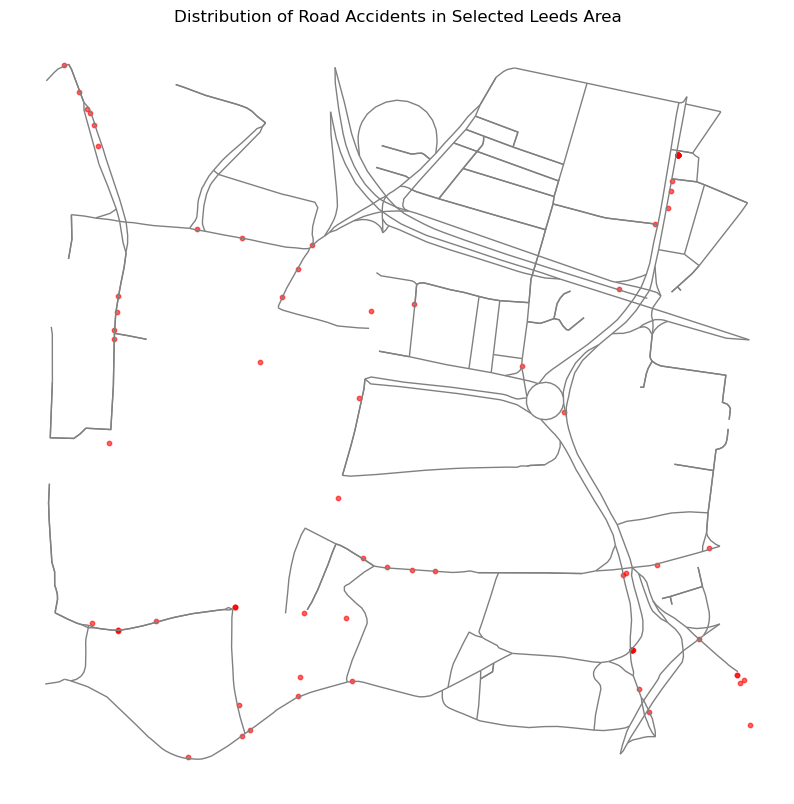

In [13]:
#taskb1
#GeoDataFrame
edges_gdf = graph_to_gdfs(G, nodes=False)

#visualizw
fig, ax = plt.subplots(figsize=(10, 10))
edges_gdf.plot(ax=ax, linewidth=1, color='gray')
accidents_in_area.plot(ax=ax, color='red', markersize=10, alpha=0.6)
ax.set_title("Distribution of Road Accidents in Selected Leeds Area")
plt.axis("off")
plt.show()

In [22]:
#taskb2
edges_gdf["accident_count"] = 0

#CRS
acc_proj = accidents_in_area.to_crs(edges_gdf.crs)

for pt in acc_proj.geometry:
    nearest_idx = edges_gdf.distance(pt).idxmin()
    edges_gdf.loc[nearest_idx, "accident_count"] += 1

# 简单计算：相邻道路的事故数量差的平均
# 邻接：两个道路如果共享端点（几何相交）
adj_diffs = []
for idx, row in edges_gdf.iterrows():
    this_geom = row.geometry
    neighbors = edges_gdf[edges_gdf.geometry.touches(this_geom)]
    for _, nbr in neighbors.iterrows():
        diff = abs(row["accident_count"] - nbr["accident_count"])
        adj_diffs.append(diff)

avg_diff = sum(adj_diffs) / len(adj_diffs) if adj_diffs else 0
print(f"Average accident count difference between touching roads: {avg_diff:.2f}")


C:\Users\ROG\AppData\Local\Temp\ipykernel_21704\1155606210.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = edges_gdf.distance(pt).idxmin()
C:\Users\ROG\AppData\Local\Temp\ipykernel_21704\1155606210.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = edges_gdf.distance(pt).idxmin()
C:\Users\ROG\AppData\Local\Temp\ipykernel_21704\1155606210.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = edges_gdf.distance(pt).idxmin()
C:\Users\ROG\AppData\Local\Temp\ipykernel_21704\1155606210.py:12: UserWarning: Geometry is in a geograp

C:\Users\ROG\AppData\Local\Temp\ipykernel_21704\1155606210.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = edges_gdf.distance(pt).idxmin()
C:\Users\ROG\AppData\Local\Temp\ipykernel_21704\1155606210.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = edges_gdf.distance(pt).idxmin()
C:\Users\ROG\AppData\Local\Temp\ipykernel_21704\1155606210.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = edges_gdf.distance(pt).idxmin()
C:\Users\ROG\AppData\Local\Temp\ipykernel_21704\1155606210.py:12: UserWarning: Geometry is in a geograp

C:\Users\ROG\AppData\Local\Temp\ipykernel_21704\1155606210.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = edges_gdf.distance(pt).idxmin()
C:\Users\ROG\AppData\Local\Temp\ipykernel_21704\1155606210.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = edges_gdf.distance(pt).idxmin()
C:\Users\ROG\AppData\Local\Temp\ipykernel_21704\1155606210.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = edges_gdf.distance(pt).idxmin()
C:\Users\ROG\AppData\Local\Temp\ipykernel_21704\1155606210.py:12: UserWarning: Geometry is in a geograp

Average accident count difference between touching roads: 0.41


67.07% of accidents occurred within 30 meters of an intersection.


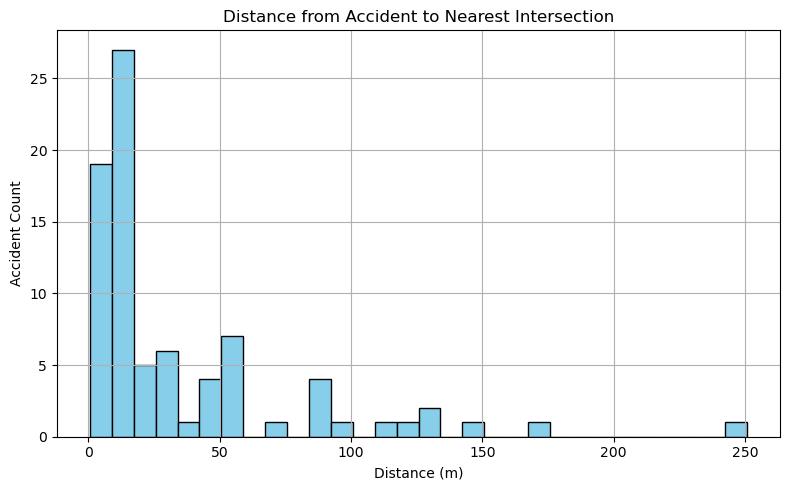

In [25]:
#taskb3
nodes_gdf, _ = graph_to_gdfs(G)
acc_proj = accidents_in_area.to_crs(epsg=3857)
nodes_proj = nodes_gdf.to_crs(epsg=3857)

nearest_dists = acc_proj.geometry.apply(lambda pt: nodes_proj.distance(pt).min())
near = (nearest_dists < 30).sum()
total = len(nearest_dists)
percentage = near / total * 100
print(f"{percentage:.2f}% of accidents occurred within 30 meters of an intersection.")

plt.figure(figsize=(8, 5))
plt.hist(nearest_dists, bins=30, color='skyblue', edgecolor='black')
plt.title("Distance from Accident to Nearest Intersection")
plt.xlabel("Distance (m)")
plt.ylabel("Accident Count")
plt.tight_layout()
plt.grid(True)
plt.show()

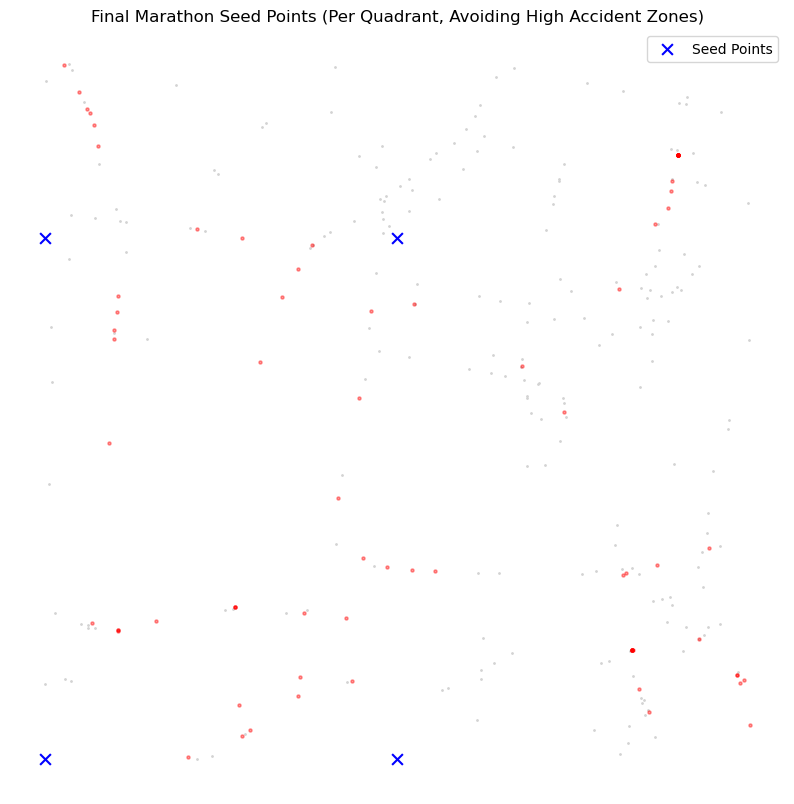

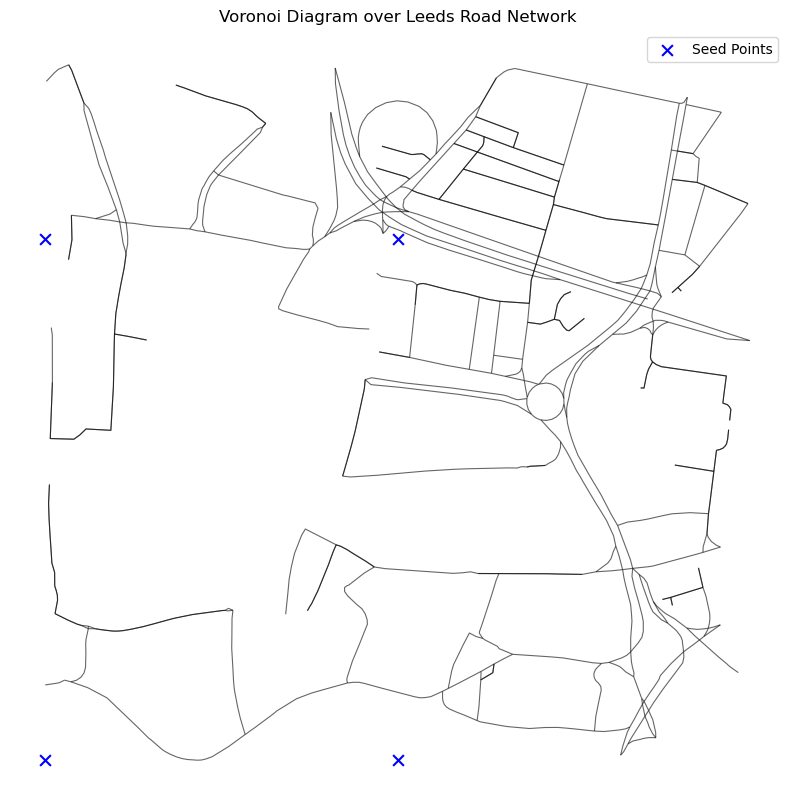

Final Seed Points (lat, lon):
(53.800649, -1.546500)
(53.800649, -1.539068)
(53.794150, -1.546500)
(53.794150, -1.539068)


In [30]:
#taskc1&2
nodes_gdf, edges_gdf = graph_to_gdfs(G)

# 5x5
minx, miny, maxx, maxy = nodes_gdf.total_bounds
grid_x = np.linspace(minx, maxx, 5)
grid_y = np.linspace(miny, maxy, 5)
grid_points = [Point(x, y) for x in grid_x for y in grid_y]

#accidents in 250 m
scores = [(pt, acc_proj.within(pt.buffer(250)).sum()) for pt in grid_points]

cx, cy = (minx + maxx) / 2, (miny + maxy) / 2
quadrants = {'top_left': [], 'top_right': [], 'bottom_left': [], 'bottom_right': []}
for pt, score in scores:
    if pt.x < cx and pt.y > cy:
        quadrants['top_left'].append((pt, score))
    elif pt.x >= cx and pt.y > cy:
        quadrants['top_right'].append((pt, score))
    elif pt.x < cx and pt.y <= cy:
        quadrants['bottom_left'].append((pt, score))
    elif pt.x >= cx and pt.y <= cy:
        quadrants['bottom_right'].append((pt, score))

#select seeds
best_points = [min(lst, key=lambda x: x[1])[0] for lst in quadrants.values() if lst]
seeds_gdf = gpd.GeoDataFrame(geometry=best_points, crs=nodes_gdf.crs)

#visualize
fig, ax = plt.subplots(figsize=(10, 10))
nodes_gdf.plot(ax=ax, markersize=1, color="lightgray")
acc_proj.plot(ax=ax, color="red", markersize=5, alpha=0.4)
seeds_gdf.plot(ax=ax, color="blue", markersize=60, marker="x", label="Seed Points")
ax.set_title("Final Marathon Seed Points (Per Quadrant, Avoiding High Accident Zones)")
plt.legend()
plt.axis("off")
plt.show()

#Voronoi
seed_coords_proj = np.array([(pt.x, pt.y) for pt in seeds_gdf.geometry])
vor = Voronoi(seed_coords_proj)

fig, ax = plt.subplots(figsize=(10, 10))
edges_gdf.plot(ax=ax, linewidth=0.8, color="black", alpha=0.6)
for simplex in vor.ridge_vertices:
    if -1 not in simplex:
        verts = [vor.vertices[i] for i in simplex]
        ax.plot(*zip(*verts), color='green', linewidth=1.5)
seeds_gdf.plot(ax=ax, color="blue", markersize=60, marker="x", label="Seed Points")
ax.set_title("Voronoi Diagram over Leeds Road Network")
plt.legend()
plt.axis("off")
plt.show()

print("Final Seed Points (lat, lon):")
for pt in seeds_gdf.to_crs(epsg=4326).geometry:
    print(f"({pt.y:.6f}, {pt.x:.6f})")

In [5]:
#taskc3


False


In [3]:
# Task D: Knowledge Graph Embedding + Visualization
#I run it on https://colab.research.google.com, using GPU
from pykeen.pipeline import pipeline
from pykeen.datasets import CoDExMedium
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


dataset = CoDExMedium(create_inverse_triples=True)

#TransE
trans_result = pipeline(
    model='TransE',
    dataset=dataset,
    training_loop='sLCWA',
    epochs=25,
    random_seed=42
)

#RotatE
rotate_result = pipeline(
    model='RotatE',
    dataset=dataset,
    training_loop='sLCWA',
    epochs=25,
    random_seed=42
)

#GCN 模型（CompGCN）
gcn_result = pipeline(
    model='CompGCN',
    dataset=dataset,
    training_loop='sLCWA',
    epochs=25,
    random_seed=42
)

#visualization of t-SNE
def plot_embeddings(model, title):
    embeddings = model.entity_representations[0]().detach().cpu().numpy()
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced[:, 0], reduced[:, 1], s=10, alpha=0.6)
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#visualization
plot_embeddings(trans_result.model, "t-SNE Visualization of TransE Entity Embeddings (CoDEx-Medium)")
plot_embeddings(rotate_result.model, "t-SNE Visualization of RotatE Entity Embeddings (CoDEx-Medium)")
plot_embeddings(gcn_result.model, "t-SNE Visualization of GCN (CompGCN) Entity Embeddings (CoDEx-Medium)")


INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.triples.triples_factory:Creating inverse triples.
Training epochs on cpu:   0%|                                                                | 0/25 [00:00<?, ?epoch/s]INFO:pykeen.triples.triples_factory:Creating inverse triples.

Training batches on cpu:  55%|███████████████████████████▌                      | 801/1450 [00:04<00:03, 172.97batch/s]


Training batches on cpu:  13%|██████▌                                           | 190/1450 [00:01<00:07, 159.47batch/s]


Training batches on cpu:  74%|████████████████████████████████████▍            | 1077/1450 [00:06<00:02, 172.73batch/s]


Training batches on cpu:  35%|█████████████████▎                                | 501/1450 [00:02<00:05, 171.10batch/s]


Training batches on cpu:  95%|██████████████████████████████████████████████▌  | 1378/1450 [00:08<00:00, 174.05batch/s]


Training batches on cpu:  54%|███████████████████████████▏                      | 790/1450 [00:04<00:03, 174.46batch/s]


Training batches on cpu:  14%|██████▊                                           | 197/1450 [00:01<00:07, 171.48batch/s]


Training batches on cpu:  76%|█████████████████████████████████████▏           | 1099/1450 [00:06<00:02, 169.84batch/s]


Training batches on cpu:  34%|████████████████▉                                 | 491/1450 [00:02<00:05, 170.08batch/s]


Training batches on cpu:  94%|█████████████████████████████████████████████▊   | 1357/1450 [00:08<00:00, 168.97batch/s]


Training batches on cpu:  53%|██████████████████████████▋                       | 774/1450 [00:04<00:03, 172.29batch/s]


Training batches on cpu:  11%|█████▌                                            | 161/1450 [00:00<00:07, 170.65batch/s]


Training batches on cpu:  73%|███████████████████████████████████▊             | 1058/1450 [00:06<00:02, 171.76batch/s]


Training batches on cpu:  32%|███████████████▊                                  | 457/1450 [00:02<00:05, 171.14batch/s]


Training batches on cpu:  93%|█████████████████████████████████████████████▋   | 1351/1450 [00:07<00:00, 172.52batch/s]


Training epochs on cpu: 100%|████████████████████████| 25/25 [03:36<00:00,  8.65s/epoch, loss=0.0628, prev_loss=0.0631]
Evaluating on cpu:   0%|                                                              | 0.00/10.3k [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|███████████████████████████████████████████████████████| 10.3k/10.3k [00:39<00:00, 259triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 40.84s seconds
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.triples.triples_factory:Creating inverse triples.
Training epochs on cpu:   0%|                                                                | 0/25 [00:00<?, ?epoch/s]INFO:pykeen.triples.triples_factory:Creating inverse triples.

Training batches on cpu:   7%|███▌                                    

Training batches on cpu:  34%|█████████████████▍                                 | 497/1450 [00:21<00:40, 23.39batch/s]


Training batches on cpu:  62%|███████████████████████████████▍                   | 893/1450 [00:38<00:23, 23.37batch/s]


Training batches on cpu:  89%|████████████████████████████████████████████▍     | 1289/1450 [00:55<00:06, 23.50batch/s]


Training batches on cpu:  16%|████████                                           | 231/1450 [00:09<00:51, 23.56batch/s]


Training batches on cpu:  43%|██████████████████████                             | 627/1450 [00:26<00:35, 23.51batch/s]


Training batches on cpu:  71%|███████████████████████████████████▎              | 1023/1450 [00:43<00:18, 23.56batch/s]


Training batches on cpu:  98%|████████████████████████████████████████████████▉ | 1419/1450 [01:00<00:01, 23.53batch/s]


Training batches on cpu:  25%|████████████▋                                      | 360/1450 [00:15<00:46, 23.57batch/s]


Training batches on cpu:  52%|██████████████████████████▌                        | 756/1450 [00:32<00:30, 22.98batch/s]


Training batches on cpu:  79%|███████████████████████████████████████▋          | 1152/1450 [00:49<00:12, 23.30batch/s]


Training batches on cpu:   6%|███▎                                                | 93/1450 [00:03<00:58, 23.29batch/s]


Training batches on cpu:  34%|█████████████████▏                                 | 489/1450 [00:20<00:40, 23.54batch/s]


Training batches on cpu:  61%|███████████████████████████████▏                   | 885/1450 [00:37<00:24, 23.21batch/s]


Training batches on cpu:  88%|████████████████████████████████████████████▏     | 1281/1450 [00:54<00:07, 23.48batch/s]


Training batches on cpu:  15%|███████▊                                           | 222/1450 [00:09<00:52, 23.48batch/s]


Training batches on cpu:  43%|█████████████████████▋                             | 618/1450 [00:26<00:35, 23.56batch/s]


Training batches on cpu:  70%|██████████████████████████████████▉               | 1014/1450 [00:43<00:18, 23.34batch/s]


Training batches on cpu:  97%|████████████████████████████████████████████████▌ | 1410/1450 [01:00<00:01, 23.34batch/s]


Training batches on cpu:  24%|████████████▎                                      | 351/1450 [00:15<00:46, 23.39batch/s]


Training batches on cpu:  52%|██████████████████████████▎                        | 747/1450 [00:32<00:30, 23.37batch/s]


Training batches on cpu:  79%|███████████████████████████████████████▍          | 1143/1450 [00:49<00:13, 23.22batch/s]


Training batches on cpu:   6%|███                                                 | 84/1450 [00:03<00:58, 23.29batch/s]


Training batches on cpu:  33%|████████████████▉                                  | 480/1450 [00:20<00:41, 23.36batch/s]


Training batches on cpu:  60%|██████████████████████████████▊                    | 876/1450 [00:37<00:24, 23.41batch/s]


Training batches on cpu:  88%|███████████████████████████████████████████▊      | 1272/1450 [00:54<00:07, 23.47batch/s]


Training batches on cpu:  15%|███████▍                                           | 213/1450 [00:09<00:53, 23.31batch/s]


Training batches on cpu:  42%|█████████████████████▍                             | 609/1450 [00:26<00:37, 22.58batch/s]


Training batches on cpu:  69%|██████████████████████████████████▋               | 1005/1450 [00:43<00:19, 23.37batch/s]


Training batches on cpu:  97%|████████████████████████████████████████████████▎ | 1401/1450 [01:00<00:02, 22.50batch/s]


Training batches on cpu:  24%|████████████                                       | 342/1450 [00:14<00:47, 23.41batch/s]


Training batches on cpu:  51%|█████████████████████████▉                         | 738/1450 [00:31<00:30, 23.22batch/s]


Training batches on cpu:  78%|███████████████████████████████████████           | 1134/1450 [00:48<00:13, 23.39batch/s]


Training batches on cpu:   5%|██▋                                                 | 75/1450 [00:03<00:59, 23.07batch/s]


Training batches on cpu:  32%|████████████████▌                                  | 471/1450 [00:20<00:41, 23.35batch/s]


Training batches on cpu:  60%|██████████████████████████████▍                    | 867/1450 [00:37<00:24, 23.40batch/s]


Training batches on cpu:  87%|███████████████████████████████████████████▌      | 1263/1450 [00:54<00:08, 22.56batch/s]


Training batches on cpu:  14%|███████                                            | 202/1450 [00:09<00:53, 23.39batch/s]


Training batches on cpu:  41%|█████████████████████                              | 598/1450 [00:26<00:36, 23.35batch/s]


Training batches on cpu:  69%|██████████████████████████████████▉                | 994/1450 [00:43<00:20, 22.76batch/s]


Training batches on cpu:  96%|███████████████████████████████████████████████▉  | 1390/1450 [01:00<00:02, 22.90batch/s]


Training batches on cpu:  23%|███████████▌                                       | 330/1450 [00:14<00:47, 23.35batch/s]


Training batches on cpu:  50%|█████████████████████████▌                         | 726/1450 [00:31<00:31, 23.21batch/s]


Training batches on cpu:  77%|██████████████████████████████████████▋           | 1122/1450 [00:48<00:14, 23.34batch/s]


Training batches on cpu:   4%|██▎                                                 | 63/1450 [00:02<00:59, 23.33batch/s]


Training batches on cpu:  32%|████████████████▏                                  | 459/1450 [00:19<00:42, 23.31batch/s]


Training batches on cpu:  59%|██████████████████████████████                     | 855/1450 [00:36<00:25, 23.31batch/s]


Training batches on cpu:  86%|███████████████████████████████████████████▏      | 1251/1450 [00:53<00:08, 23.29batch/s]


Training batches on cpu:  13%|██████▊                                            | 192/1450 [00:08<00:53, 23.48batch/s]


Training batches on cpu:  41%|████████████████████▋                              | 588/1450 [00:25<00:36, 23.44batch/s]


Training batches on cpu:  68%|██████████████████████████████████▌                | 984/1450 [00:42<00:19, 23.42batch/s]


Training batches on cpu:  95%|███████████████████████████████████████████████▌  | 1380/1450 [00:59<00:03, 23.33batch/s]


Training batches on cpu:  22%|███████████▎                                       | 321/1450 [00:13<00:48, 23.31batch/s]


Training batches on cpu:  49%|█████████████████████████▏                         | 717/1450 [00:30<00:31, 23.18batch/s]


Training batches on cpu:  77%|██████████████████████████████████████▍           | 1113/1450 [00:47<00:14, 23.32batch/s]


Training batches on cpu:   4%|█▉                                                  | 54/1450 [00:02<01:00, 23.00batch/s]


Training batches on cpu:  31%|███████████████▊                                   | 450/1450 [00:19<00:43, 23.14batch/s]


Training batches on cpu:  58%|█████████████████████████████▊                     | 846/1450 [00:36<00:25, 23.34batch/s]


Training batches on cpu:  86%|██████████████████████████████████████████▊       | 1242/1450 [00:53<00:08, 23.18batch/s]


Training batches on cpu:  13%|██████▍                                            | 183/1450 [00:07<00:54, 23.04batch/s]


Training batches on cpu:  40%|████████████████████▎                              | 579/1450 [00:24<00:38, 22.83batch/s]


Training batches on cpu:  67%|██████████████████████████████████▎                | 975/1450 [00:41<00:20, 23.10batch/s]


Training batches on cpu:  95%|███████████████████████████████████████████████▎  | 1371/1450 [00:58<00:03, 23.20batch/s]


Training batches on cpu:  22%|██████████▉                                        | 312/1450 [00:13<00:49, 22.87batch/s]


Training batches on cpu:  49%|████████████████████████▉                          | 708/1450 [00:30<00:32, 22.69batch/s]


Training batches on cpu:  76%|██████████████████████████████████████            | 1104/1450 [00:47<00:14, 23.20batch/s]


Training batches on cpu:   3%|█▌                                                  | 45/1450 [00:01<01:00, 23.35batch/s]


Training batches on cpu:  30%|███████████████▌                                   | 441/1450 [00:18<00:43, 23.15batch/s]


Training batches on cpu:  58%|█████████████████████████████▍                     | 837/1450 [00:36<00:26, 22.97batch/s]


Training batches on cpu:  85%|██████████████████████████████████████████▌       | 1233/1450 [00:53<00:09, 23.24batch/s]


Training batches on cpu:  12%|██████                                             | 174/1450 [00:07<00:55, 23.13batch/s]


Training batches on cpu:  39%|████████████████████                               | 570/1450 [00:24<00:37, 23.40batch/s]


Training batches on cpu:  67%|█████████████████████████████████▉                 | 966/1450 [00:41<00:20, 23.24batch/s]


Training batches on cpu:  94%|██████████████████████████████████████████████▉   | 1362/1450 [00:58<00:03, 23.38batch/s]


Training batches on cpu:  21%|██████████▋                                        | 303/1450 [00:13<00:49, 23.11batch/s]


Training batches on cpu:  48%|████████████████████████▌                          | 699/1450 [00:30<00:32, 23.35batch/s]


Training batches on cpu:  76%|█████████████████████████████████████▊            | 1095/1450 [00:47<00:15, 23.35batch/s]


Training batches on cpu:   2%|█▎                                                  | 36/1450 [00:01<01:00, 23.31batch/s]


Training batches on cpu:  30%|███████████████▏                                   | 432/1450 [00:18<00:45, 22.32batch/s]


Training batches on cpu:  57%|█████████████████████████████                      | 828/1450 [00:35<00:26, 23.20batch/s]


Training batches on cpu:  84%|██████████████████████████████████████████▏       | 1224/1450 [00:53<00:09, 23.07batch/s]


Training batches on cpu:  11%|█████▊                                             | 165/1450 [00:07<00:55, 23.29batch/s]


Training batches on cpu:  39%|███████████████████▋                               | 561/1450 [00:24<00:38, 23.37batch/s]


Training batches on cpu:  66%|█████████████████████████████████▋                 | 957/1450 [00:41<00:21, 23.37batch/s]


Training batches on cpu:  93%|██████████████████████████████████████████████▋   | 1353/1450 [00:58<00:04, 23.25batch/s]


Training batches on cpu:  20%|██████████▎                                        | 293/1450 [00:12<00:50, 22.74batch/s]


Training batches on cpu:  48%|████████████████████████▏                          | 689/1450 [00:29<00:32, 23.15batch/s]


Training batches on cpu:  75%|█████████████████████████████████████▍            | 1085/1450 [00:46<00:16, 22.60batch/s]


Training batches on cpu:   2%|▉                                                   | 27/1450 [00:01<01:01, 23.23batch/s]


Training batches on cpu:  29%|██████████████▉                                    | 423/1450 [00:18<00:44, 23.05batch/s]


Training batches on cpu:  56%|████████████████████████████▊                      | 819/1450 [00:35<00:26, 23.37batch/s]


Training batches on cpu:  84%|█████████████████████████████████████████▉        | 1215/1450 [00:52<00:10, 22.67batch/s]


Training epochs on cpu: 100%|████████████████████████| 25/25 [26:04<00:00, 62.60s/epoch, loss=0.0422, prev_loss=0.0431]
Evaluating on cpu:   0%|                                                              | 0.00/10.3k [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████████████████████████████████████████████████| 10.3k/10.3k [02:15<00:00, 76.2triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 136.21s seconds
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.triples.triples_factory:Creating inverse triples.
Training epochs on cpu:   0%|                                                                | 0/25 [00:00<?, ?epoch/s]INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch ea

Training batches on cpu:  12%|██████                                             | 174/1449 [00:48<05:54,  3.59batch/s]


Training batches on cpu:  21%|██████████▊                                        | 306/1449 [01:26<05:23,  3.53batch/s]


Training batches on cpu:  30%|███████████████▍                                   | 438/1449 [02:02<04:39,  3.62batch/s]


Training batches on cpu:  39%|████████████████████                               | 570/1449 [02:39<04:04,  3.59batch/s]


Training batches on cpu:  48%|████████████████████████▋                          | 702/1449 [03:16<03:28,  3.59batch/s]


Training batches on cpu:  58%|█████████████████████████████▎                     | 834/1449 [03:53<02:53,  3.55batch/s]


Training batches on cpu:  67%|██████████████████████████████████                 | 966/1449 [04:30<02:13,  3.62batch/s]


Training batches on cpu:  76%|█████████████████████████████████████▉            | 1098/1449 [05:07<01:38,  3.56batch/s]


Training batches on cpu:  85%|██████████████████████████████████████████▍       | 1230/1449 [05:44<01:00,  3.60batch/s]


Training batches on cpu:  94%|██████████████████████████████████████████████▉   | 1362/1449 [06:20<00:24,  3.56batch/s]


Training batches on cpu:   3%|█▌                                                  | 43/1449 [00:12<06:32,  3.58batch/s]


Training batches on cpu:  12%|██████▏                                            | 175/1449 [00:48<05:47,  3.67batch/s]


Training batches on cpu:  21%|██████████▊                                        | 307/1449 [01:24<05:10,  3.68batch/s]


Training batches on cpu:  30%|███████████████▍                                   | 439/1449 [02:00<04:37,  3.63batch/s]


Training batches on cpu:  39%|████████████████████                               | 571/1449 [02:36<03:56,  3.72batch/s]


Training batches on cpu:  49%|████████████████████████▋                          | 703/1449 [03:12<03:21,  3.71batch/s]


Training batches on cpu:  58%|█████████████████████████████▍                     | 835/1449 [03:48<02:47,  3.67batch/s]


Training batches on cpu:  67%|██████████████████████████████████                 | 967/1449 [04:23<02:09,  3.71batch/s]


Training batches on cpu:  76%|█████████████████████████████████████▉            | 1099/1449 [04:59<01:35,  3.65batch/s]


Training batches on cpu:  85%|██████████████████████████████████████████▍       | 1231/1449 [05:35<00:58,  3.72batch/s]


Training batches on cpu:  94%|███████████████████████████████████████████████   | 1363/1449 [06:11<00:23,  3.68batch/s]


Training batches on cpu:   3%|█▌                                                  | 44/1449 [00:11<06:22,  3.68batch/s]


Training batches on cpu:  12%|██████▏                                            | 176/1449 [00:47<05:48,  3.66batch/s]


Training batches on cpu:  21%|██████████▊                                        | 308/1449 [01:23<05:12,  3.66batch/s]


Training batches on cpu:  30%|███████████████▍                                   | 440/1449 [01:59<04:37,  3.64batch/s]


Training batches on cpu:  39%|████████████████████▏                              | 572/1449 [02:35<03:57,  3.69batch/s]


Training batches on cpu:  49%|████████████████████████▊                          | 704/1449 [03:11<03:20,  3.71batch/s]


Training batches on cpu:  58%|█████████████████████████████▍                     | 836/1449 [03:47<02:45,  3.69batch/s]


Training batches on cpu:  67%|██████████████████████████████████                 | 968/1449 [04:23<02:09,  3.70batch/s]


Training batches on cpu:  76%|█████████████████████████████████████▉            | 1100/1449 [04:58<01:35,  3.66batch/s]


Training batches on cpu:  85%|██████████████████████████████████████████▌       | 1232/1449 [05:34<00:59,  3.66batch/s]


Training batches on cpu:  94%|███████████████████████████████████████████████   | 1364/1449 [06:10<00:24,  3.45batch/s]


Training batches on cpu:   3%|█▌                                                  | 45/1449 [00:12<06:37,  3.53batch/s]


Training batches on cpu:  12%|██████▏                                            | 177/1449 [00:49<05:53,  3.60batch/s]


Training batches on cpu:  21%|██████████▉                                        | 309/1449 [01:25<05:14,  3.63batch/s]


Training batches on cpu:  30%|███████████████▌                                   | 441/1449 [02:02<04:39,  3.60batch/s]


Training batches on cpu:  40%|████████████████████▏                              | 573/1449 [02:39<04:06,  3.55batch/s]


Training batches on cpu:  49%|████████████████████████▊                          | 705/1449 [03:16<03:33,  3.48batch/s]


Training batches on cpu:  58%|█████████████████████████████▍                     | 837/1449 [03:56<03:13,  3.17batch/s]


Training batches on cpu:  67%|██████████████████████████████████                 | 969/1449 [04:35<02:16,  3.52batch/s]


Training batches on cpu:  76%|█████████████████████████████████████▉            | 1101/1449 [05:12<01:41,  3.44batch/s]


Training batches on cpu:  85%|██████████████████████████████████████████▌       | 1233/1449 [05:50<00:59,  3.61batch/s]


Training batches on cpu:  94%|███████████████████████████████████████████████   | 1365/1449 [06:28<00:23,  3.59batch/s]


Training batches on cpu:   3%|█▋                                                  | 46/1449 [00:12<06:27,  3.62batch/s]


Training batches on cpu:  12%|██████▎                                            | 178/1449 [00:49<06:14,  3.39batch/s]


Training batches on cpu:  21%|██████████▉                                        | 310/1449 [01:26<05:22,  3.53batch/s]


Training batches on cpu:  31%|███████████████▌                                   | 442/1449 [02:03<04:36,  3.65batch/s]


Training batches on cpu:  40%|████████████████████▏                              | 574/1449 [02:40<04:05,  3.56batch/s]


Training batches on cpu:  49%|████████████████████████▊                          | 706/1449 [03:18<03:32,  3.50batch/s]


Training batches on cpu:  58%|█████████████████████████████▍                     | 838/1449 [03:55<02:50,  3.59batch/s]


Training batches on cpu:  67%|██████████████████████████████████▏                | 970/1449 [04:31<02:14,  3.56batch/s]


Training batches on cpu:  76%|██████████████████████████████████████            | 1102/1449 [05:08<01:35,  3.64batch/s]


Training batches on cpu:  85%|██████████████████████████████████████████▌       | 1234/1449 [05:44<00:59,  3.61batch/s]


Training batches on cpu:  94%|███████████████████████████████████████████████▏  | 1366/1449 [06:21<00:23,  3.60batch/s]


Training batches on cpu:   3%|█▋                                                  | 47/1449 [00:13<06:32,  3.57batch/s]


Training batches on cpu:  12%|██████▎                                            | 179/1449 [00:49<05:50,  3.62batch/s]


Training batches on cpu:  21%|██████████▉                                        | 311/1449 [01:26<05:15,  3.61batch/s]


Training batches on cpu:  31%|███████████████▌                                   | 443/1449 [02:03<04:40,  3.58batch/s]


Training batches on cpu:  40%|████████████████████▏                              | 575/1449 [02:40<04:03,  3.59batch/s]


Training batches on cpu:  49%|████████████████████████▉                          | 707/1449 [03:16<03:28,  3.56batch/s]


Training batches on cpu:  58%|█████████████████████████████▌                     | 839/1449 [03:53<02:52,  3.54batch/s]


Training batches on cpu:  67%|██████████████████████████████████▏                | 971/1449 [04:30<02:12,  3.62batch/s]


Training batches on cpu:  76%|██████████████████████████████████████            | 1103/1449 [05:07<01:39,  3.49batch/s]


Training batches on cpu:  85%|██████████████████████████████████████████▌       | 1235/1449 [05:45<01:02,  3.44batch/s]


Training batches on cpu:  94%|███████████████████████████████████████████████▏  | 1367/1449 [06:24<00:23,  3.44batch/s]


Training batches on cpu:   3%|█▋                                                  | 48/1449 [00:13<06:38,  3.52batch/s]


Training batches on cpu:  12%|██████▎                                            | 180/1449 [00:49<05:54,  3.58batch/s]


Training batches on cpu:  22%|██████████▉                                        | 312/1449 [01:27<05:17,  3.58batch/s]


Training batches on cpu:  31%|███████████████▋                                   | 444/1449 [02:05<04:52,  3.44batch/s]


Training batches on cpu:  40%|████████████████████▎                              | 576/1449 [02:42<04:02,  3.60batch/s]


Training batches on cpu:  49%|████████████████████████▉                          | 708/1449 [03:19<03:30,  3.52batch/s]


Training batches on cpu:  58%|█████████████████████████████▌                     | 840/1449 [03:56<02:47,  3.63batch/s]


Training batches on cpu:  67%|██████████████████████████████████▏                | 972/1449 [04:33<02:13,  3.58batch/s]


Training batches on cpu:  76%|██████████████████████████████████████            | 1104/1449 [05:10<01:35,  3.62batch/s]


Training batches on cpu:  85%|██████████████████████████████████████████▋       | 1236/1449 [05:46<00:59,  3.58batch/s]


Training batches on cpu:  94%|███████████████████████████████████████████████▏  | 1368/1449 [06:23<00:22,  3.61batch/s]


Training batches on cpu:   3%|█▊                                                  | 49/1449 [00:13<06:27,  3.61batch/s]


Training batches on cpu:  12%|██████▎                                            | 181/1449 [00:50<05:54,  3.58batch/s]


Training batches on cpu:  22%|███████████                                        | 313/1449 [01:27<05:24,  3.50batch/s]


Training batches on cpu:  31%|███████████████▋                                   | 445/1449 [02:04<04:53,  3.43batch/s]


Training batches on cpu:  40%|████████████████████▎                              | 577/1449 [02:42<04:06,  3.54batch/s]


Training batches on cpu:  49%|████████████████████████▉                          | 709/1449 [03:19<03:24,  3.62batch/s]


Training batches on cpu:  58%|█████████████████████████████▌                     | 841/1449 [03:56<02:48,  3.62batch/s]


Training batches on cpu:  67%|██████████████████████████████████▏                | 973/1449 [04:33<02:16,  3.49batch/s]


Training batches on cpu:  76%|██████████████████████████████████████▏           | 1105/1449 [05:11<01:38,  3.49batch/s]


Training batches on cpu:  85%|██████████████████████████████████████████▋       | 1237/1449 [05:49<01:00,  3.51batch/s]


Training batches on cpu:  94%|███████████████████████████████████████████████▏  | 1369/1449 [06:26<00:22,  3.57batch/s]


Training batches on cpu:   3%|█▊                                                  | 50/1449 [00:14<06:43,  3.47batch/s]


Training batches on cpu:  13%|██████▍                                            | 182/1449 [00:51<05:58,  3.54batch/s]


Training batches on cpu:  22%|███████████                                        | 314/1449 [01:30<05:37,  3.36batch/s]


Training batches on cpu:  31%|███████████████▋                                   | 446/1449 [02:08<04:55,  3.40batch/s]


Training batches on cpu:  40%|████████████████████▎                              | 578/1449 [02:45<04:06,  3.54batch/s]


Training batches on cpu:  49%|████████████████████████▉                          | 710/1449 [03:23<03:27,  3.57batch/s]


Training batches on cpu:  58%|█████████████████████████████▋                     | 842/1449 [04:01<02:51,  3.54batch/s]


Training batches on cpu:  67%|██████████████████████████████████▎                | 974/1449 [04:39<02:18,  3.43batch/s]


Training batches on cpu:  76%|██████████████████████████████████████▏           | 1106/1449 [05:17<01:37,  3.51batch/s]


Training batches on cpu:  85%|██████████████████████████████████████████▋       | 1238/1449 [05:55<01:00,  3.47batch/s]


Training batches on cpu:  95%|███████████████████████████████████████████████▎  | 1370/1449 [06:32<00:22,  3.44batch/s]


Training batches on cpu:   4%|█▊                                                  | 51/1449 [00:14<06:35,  3.53batch/s]


Training batches on cpu:  13%|██████▍                                            | 183/1449 [00:52<05:51,  3.60batch/s]


Training batches on cpu:  22%|███████████                                        | 315/1449 [01:29<05:33,  3.40batch/s]


Training batches on cpu:  31%|███████████████▋                                   | 447/1449 [02:07<04:44,  3.52batch/s]


Training batches on cpu:  40%|████████████████████▍                              | 579/1449 [02:44<04:06,  3.53batch/s]


Training batches on cpu:  49%|█████████████████████████                          | 711/1449 [03:22<03:33,  3.46batch/s]


Training batches on cpu:  58%|█████████████████████████████▋                     | 843/1449 [04:00<02:56,  3.44batch/s]


Training batches on cpu:  67%|██████████████████████████████████▎                | 975/1449 [04:37<02:13,  3.56batch/s]


Training batches on cpu:  76%|██████████████████████████████████████▏           | 1107/1449 [05:14<01:35,  3.59batch/s]


Training batches on cpu:  86%|██████████████████████████████████████████▊       | 1239/1449 [05:51<00:58,  3.57batch/s]


Training batches on cpu:  95%|███████████████████████████████████████████████▎  | 1371/1449 [06:29<00:21,  3.59batch/s]


Training batches on cpu:   4%|█▊                                                  | 52/1449 [00:14<06:27,  3.60batch/s]


Training batches on cpu:  13%|██████▍                                            | 184/1449 [00:53<06:06,  3.46batch/s]


Training batches on cpu:  22%|███████████                                        | 316/1449 [01:31<05:42,  3.31batch/s]


Training batches on cpu:  31%|███████████████▊                                   | 448/1449 [02:09<04:45,  3.51batch/s]


Training batches on cpu:  40%|████████████████████▍                              | 580/1449 [02:46<04:06,  3.52batch/s]


Training batches on cpu:  49%|█████████████████████████                          | 712/1449 [03:23<03:25,  3.59batch/s]


Training batches on cpu:  58%|█████████████████████████████▋                     | 844/1449 [04:00<02:48,  3.59batch/s]


Training batches on cpu:  67%|██████████████████████████████████▎                | 976/1449 [04:40<02:26,  3.23batch/s]


Training batches on cpu:  76%|██████████████████████████████████████▏           | 1108/1449 [05:18<01:36,  3.52batch/s]


Training batches on cpu:  86%|██████████████████████████████████████████▊       | 1240/1449 [05:56<01:00,  3.48batch/s]


Training batches on cpu:  95%|███████████████████████████████████████████████▎  | 1372/1449 [06:34<00:22,  3.45batch/s]


Training batches on cpu:   4%|█▉                                                  | 53/1449 [00:15<06:30,  3.58batch/s]


Training batches on cpu:  13%|██████▌                                            | 185/1449 [00:52<05:55,  3.56batch/s]


Training batches on cpu:  22%|███████████▏                                       | 317/1449 [01:30<05:38,  3.35batch/s]


Training batches on cpu:  31%|███████████████▊                                   | 449/1449 [02:08<04:44,  3.52batch/s]


Training batches on cpu:  40%|████████████████████▍                              | 581/1449 [02:46<04:02,  3.57batch/s]


Training batches on cpu:  49%|█████████████████████████                          | 713/1449 [03:23<03:24,  3.59batch/s]


Training batches on cpu:  58%|█████████████████████████████▋                     | 845/1449 [04:01<02:51,  3.52batch/s]


Training batches on cpu:  67%|██████████████████████████████████▍                | 977/1449 [04:39<02:13,  3.54batch/s]


Training batches on cpu:  77%|██████████████████████████████████████▎           | 1109/1449 [05:16<01:38,  3.44batch/s]


Training batches on cpu:  86%|██████████████████████████████████████████▊       | 1241/1449 [05:55<00:58,  3.53batch/s]


Training batches on cpu:  95%|███████████████████████████████████████████████▍  | 1373/1449 [06:33<00:21,  3.46batch/s]


Training batches on cpu:   4%|█▉                                                  | 54/1449 [00:15<06:40,  3.48batch/s]


Training batches on cpu:  13%|██████▌                                            | 186/1449 [00:52<05:54,  3.56batch/s]


Training batches on cpu:  22%|███████████▏                                       | 318/1449 [01:30<05:23,  3.49batch/s]


Training batches on cpu:  31%|███████████████▊                                   | 450/1449 [02:07<04:44,  3.51batch/s]


Training batches on cpu:  40%|████████████████████▍                              | 582/1449 [02:45<04:03,  3.57batch/s]


Training batches on cpu:  49%|█████████████████████████▏                         | 714/1449 [03:22<03:26,  3.55batch/s]


Training batches on cpu:  58%|█████████████████████████████▊                     | 846/1449 [04:00<02:50,  3.54batch/s]


Training batches on cpu:  67%|██████████████████████████████████▍                | 978/1449 [04:37<02:11,  3.59batch/s]


Training batches on cpu:  77%|██████████████████████████████████████▎           | 1110/1449 [05:14<01:38,  3.45batch/s]


Training batches on cpu:  86%|██████████████████████████████████████████▊       | 1242/1449 [05:52<00:59,  3.47batch/s]


Training batches on cpu:  95%|███████████████████████████████████████████████▍  | 1374/1449 [06:30<00:21,  3.47batch/s]


Training batches on cpu:   4%|█▉                                                  | 55/1449 [00:15<06:35,  3.52batch/s]


Training batches on cpu:  13%|██████▌                                            | 187/1449 [00:52<05:57,  3.53batch/s]


Training batches on cpu:  22%|███████████▏                                       | 319/1449 [01:29<05:16,  3.57batch/s]


Training batches on cpu:  31%|███████████████▊                                   | 451/1449 [02:07<04:39,  3.56batch/s]


Training batches on cpu:  40%|████████████████████▌                              | 583/1449 [02:44<04:02,  3.58batch/s]


Training batches on cpu:  49%|█████████████████████████▏                         | 715/1449 [03:22<03:28,  3.52batch/s]


Training batches on cpu:  58%|█████████████████████████████▊                     | 847/1449 [03:59<02:48,  3.57batch/s]


Training batches on cpu:  68%|██████████████████████████████████▍                | 979/1449 [04:36<02:13,  3.53batch/s]


Training batches on cpu:  77%|██████████████████████████████████████▎           | 1111/1449 [05:14<01:35,  3.52batch/s]


Training batches on cpu:  86%|██████████████████████████████████████████▉       | 1243/1449 [05:52<00:58,  3.53batch/s]


Training batches on cpu:  95%|███████████████████████████████████████████████▍  | 1375/1449 [06:29<00:20,  3.55batch/s]


Training batches on cpu:   4%|██                                                  | 56/1449 [00:15<06:32,  3.55batch/s]


Training batches on cpu:  13%|██████▌                                            | 188/1449 [00:53<06:00,  3.50batch/s]


Training batches on cpu:  22%|███████████▎                                       | 320/1449 [01:30<05:19,  3.53batch/s]


Training batches on cpu:  31%|███████████████▉                                   | 452/1449 [02:08<04:45,  3.49batch/s]


Training batches on cpu:  40%|████████████████████▌                              | 584/1449 [02:46<04:10,  3.45batch/s]


Training batches on cpu:  49%|█████████████████████████▏                         | 716/1449 [03:23<03:33,  3.43batch/s]


Training batches on cpu:  59%|█████████████████████████████▊                     | 848/1449 [04:01<02:49,  3.54batch/s]


Training batches on cpu:  68%|██████████████████████████████████▍                | 980/1449 [04:39<02:12,  3.53batch/s]


Training batches on cpu:  77%|██████████████████████████████████████▎           | 1112/1449 [05:16<01:36,  3.48batch/s]


Training batches on cpu:  86%|██████████████████████████████████████████▉       | 1244/1449 [05:54<00:57,  3.56batch/s]


Training batches on cpu:  95%|███████████████████████████████████████████████▍  | 1376/1449 [06:31<00:20,  3.50batch/s]


Training batches on cpu:   4%|██                                                  | 57/1449 [00:16<06:53,  3.37batch/s]


Training batches on cpu:  13%|██████▋                                            | 189/1449 [00:54<06:01,  3.49batch/s]


Training batches on cpu:  22%|███████████▎                                       | 321/1449 [01:32<05:20,  3.52batch/s]


Training batches on cpu:  31%|███████████████▉                                   | 453/1449 [02:10<04:45,  3.49batch/s]


Training batches on cpu:  40%|████████████████████▌                              | 585/1449 [02:47<04:11,  3.44batch/s]


Training batches on cpu:  49%|█████████████████████████▏                         | 717/1449 [03:25<03:45,  3.25batch/s]


Training batches on cpu:  59%|█████████████████████████████▉                     | 849/1449 [04:03<02:53,  3.46batch/s]


Training batches on cpu:  68%|██████████████████████████████████▌                | 981/1449 [04:40<02:11,  3.55batch/s]


Training batches on cpu:  77%|██████████████████████████████████████▍           | 1113/1449 [05:18<01:33,  3.60batch/s]


Training batches on cpu:  86%|██████████████████████████████████████████▉       | 1245/1449 [05:55<00:58,  3.48batch/s]


Training batches on cpu:  95%|███████████████████████████████████████████████▌  | 1377/1449 [06:33<00:20,  3.50batch/s]


Training batches on cpu:   4%|██                                                  | 58/1449 [00:16<06:25,  3.61batch/s]


Training batches on cpu:  13%|██████▋                                            | 190/1449 [00:53<05:54,  3.56batch/s]


Training batches on cpu:  22%|███████████▎                                       | 322/1449 [01:31<05:10,  3.63batch/s]


Training batches on cpu:  31%|███████████████▉                                   | 454/1449 [02:07<04:35,  3.62batch/s]


Training batches on cpu:  40%|████████████████████▋                              | 586/1449 [02:44<04:00,  3.59batch/s]


Training batches on cpu:  50%|█████████████████████████▎                         | 718/1449 [03:20<03:24,  3.58batch/s]


Training batches on cpu:  59%|█████████████████████████████▉                     | 850/1449 [03:57<02:45,  3.62batch/s]


Training batches on cpu:  68%|██████████████████████████████████▌                | 982/1449 [04:34<02:07,  3.65batch/s]


Training batches on cpu:  77%|██████████████████████████████████████▍           | 1114/1449 [05:10<01:34,  3.54batch/s]


Training batches on cpu:  86%|██████████████████████████████████████████▉       | 1246/1449 [05:47<00:55,  3.63batch/s]


Training batches on cpu:  95%|███████████████████████████████████████████████▌  | 1378/1449 [06:24<00:19,  3.56batch/s]


Training batches on cpu:   4%|██                                                  | 59/1449 [00:16<06:31,  3.55batch/s]


Training batches on cpu:  13%|██████▋                                            | 191/1449 [00:53<05:48,  3.61batch/s]


Training batches on cpu:  22%|███████████▎                                       | 323/1449 [01:30<05:17,  3.55batch/s]


Training batches on cpu:  31%|████████████████                                   | 455/1449 [02:07<04:45,  3.48batch/s]


Training batches on cpu:  41%|████████████████████▋                              | 587/1449 [02:44<03:57,  3.62batch/s]


Training batches on cpu:  50%|█████████████████████████▎                         | 719/1449 [03:21<03:22,  3.60batch/s]


Training batches on cpu:  59%|█████████████████████████████▉                     | 851/1449 [03:58<02:44,  3.63batch/s]


Training batches on cpu:  68%|██████████████████████████████████▌                | 983/1449 [04:34<02:09,  3.60batch/s]


Training batches on cpu:  77%|██████████████████████████████████████▍           | 1115/1449 [05:10<01:32,  3.62batch/s]


Training batches on cpu:  86%|███████████████████████████████████████████       | 1247/1449 [05:47<00:55,  3.66batch/s]


Training batches on cpu:  95%|███████████████████████████████████████████████▌  | 1379/1449 [06:23<00:19,  3.67batch/s]


Training batches on cpu:   4%|██▏                                                 | 60/1449 [00:16<06:19,  3.66batch/s]


Training batches on cpu:  13%|██████▊                                            | 192/1449 [00:53<05:53,  3.56batch/s]


Training batches on cpu:  22%|███████████▍                                       | 324/1449 [01:29<05:08,  3.65batch/s]


Training batches on cpu:  31%|████████████████                                   | 456/1449 [02:06<04:36,  3.59batch/s]


Training batches on cpu:  41%|████████████████████▋                              | 588/1449 [02:42<03:56,  3.64batch/s]


Training batches on cpu:  50%|█████████████████████████▎                         | 720/1449 [03:19<03:23,  3.57batch/s]


Training batches on cpu:  59%|█████████████████████████████▉                     | 852/1449 [03:56<02:45,  3.61batch/s]


Training batches on cpu:  68%|██████████████████████████████████▋                | 984/1449 [04:33<02:14,  3.46batch/s]


Training batches on cpu:  77%|██████████████████████████████████████▌           | 1116/1449 [05:10<01:35,  3.50batch/s]


Training batches on cpu:  86%|███████████████████████████████████████████       | 1248/1449 [05:48<00:56,  3.54batch/s]


Training batches on cpu:  95%|███████████████████████████████████████████████▌  | 1380/1449 [06:26<00:19,  3.49batch/s]


Training batches on cpu:   4%|██▏                                                 | 61/1449 [00:17<06:41,  3.46batch/s]


Training epochs on cpu:  76%|███████████████▉     | 19/25 [2:09:42<40:57, 409.61s/epoch, loss=0.0675, prev_loss=0.0699]


KeyboardInterrupt: 